import packages

In [1]:
import os
import random
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

## Data Manipulation

In [5]:
import torchvision.transforms as transforms
compose = transforms.Compose([
    transforms.CenterCrop((200,330)),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
data_dir = '/content/drive/MyDrive/dataset_doeun_0825/spec/'
dataset = torchvision.datasets.ImageFolder(data_dir,transform=compose)

In [ ]:
len(dataset)

1190

train / test 나누기: test set는 200개로 CV 할 때마다 성능 검사

In [6]:
from torch.utils.data import random_split
seed_everything(42)
train_data, test_data = random_split(dataset,[990,200])

In [7]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle =True)

In [ ]:
num=[]
for _, test_target in testloader:
  num += test_target
print(sum(num))

tensor(111)


5-fold로 데이터 나누기

In [8]:
from sklearn.model_selection import KFold
from torch.utils import data

seed_everything(12)
folds = KFold(n_splits=5,shuffle=True)
train = []
valid = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data)):
    dataset_train = data.Subset(train_data, train_idx)
    dataset_valid = data.Subset(train_data, valid_idx)
    trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle =True)
    train.append(trainloader)
    validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=10, shuffle=True)
    valid.append(validloader)

In [ ]:
for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data)):
  print(i_fold)
  print('train',valid_idx)

0
train [  4   7  13  15  16  20  34  38  43  54  61  75  77  89  90  97  98 101
 111 115 116 117 120 122 131 133 153 161 163 164 167 175 177 178 183 187
 190 191 194 196 206 207 213 216 218 221 226 229 242 248 249 252 268 270
 274 277 278 282 283 289 296 301 303 313 321 326 330 338 343 344 347 350
 351 352 353 355 362 363 369 371 377 379 381 388 390 391 401 404 405 408
 410 415 416 421 431 433 440 459 465 467 468 471 473 474 475 476 483 492
 500 501 502 508 519 525 535 543 545 552 570 571 579 581 592 594 596 605
 606 613 627 632 633 639 647 649 661 665 667 669 671 674 676 677 691 694
 700 710 721 727 730 737 740 744 760 776 781 782 786 793 798 803 809 810
 813 815 824 825 826 829 835 838 843 850 858 861 865 867 869 874 897 911
 915 924 928 932 934 942 947 948 950 952 953 954 955 958 966 982 984 988]
1
train [  0   2   3   5   8  10  27  28  44  45  51  59  66  69  74  81  84  85
  88  92  93 109 124 129 130 132 137 143 155 157 160 165 166 169 173 188
 204 208 214 220 225 227 231 245 2

torch.Size([10, 3, 224, 224])
torch.Size([3, 224, 224])


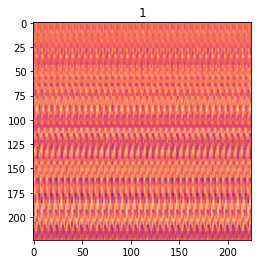

In [ ]:
import matplotlib.pyplot as plt
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in trainloader:
    index = 5
    print(data.shape)
    img = data[index]
    print(img.shape)
    pic = ToPILImage(img)
    plt.title(int(target[index]))
    plt.imshow(pic)
    plt.show()
    break

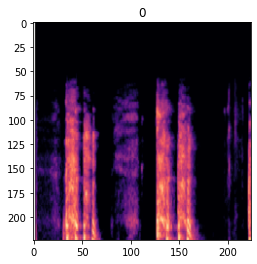

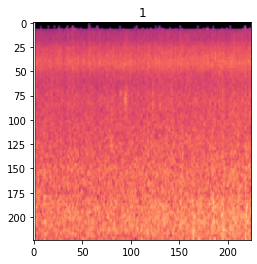

In [ ]:
import matplotlib.pyplot as plt
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in trainloader:
    img = data[4]
    pic = ToPILImage(img)
    plt.title(int(target[4]))
    plt.imshow(pic)
    plt.show()
    img = data[2]
    pic = ToPILImage(img)
    plt.title(int(target[2]))
    plt.imshow(pic)
    plt.show()
    break

In [ ]:
print(len(train[0]),len(valid[0]))

80 20


### Resnet

In [9]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [15]:
from torchvision.models import resnet50
model = resnet50(pretrained = False)

model.l1 = nn.Linear(2048, 256)
model.l2 = nn.Linear(256, 32)
model.l3 = nn.Linear(32, 2)
nn.init.kaiming_normal_(model.l1.weight)
nn.init.kaiming_normal_(model.l2.weight)
nn.init.kaiming_normal_(model.l3.weight)

model.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         model.l1,
                         nn.Dropout(0.5),
                         nn.BatchNorm1d(256),
                         model.l2,
                         nn.Dropout(0.5),
                         nn.BatchNorm1d(32),
                         model.l3,
                         nn.Dropout(0.5)
                         )

model = model.to(device)

In [ ]:
n = 0
for data, target in train[0]:
    print(data.shape) # (batch, channel, width, height)
    break

data = data.to(device)

with torch.no_grad():
    y = model(data)
    print(y)
    print(np.argmax(y.cpu(), axis=1), target)

torch.Size([10, 3, 224, 224])
tensor([[-0.0000, -0.0000],
        [ 0.0000,  0.0000],
        [-3.3249, -0.0000],
        [ 0.0000,  0.0000],
        [-0.0000,  0.6838],
        [-1.6858, -1.4802],
        [ 0.0000,  1.3791],
        [ 2.9711,  0.0000],
        [ 0.0000,  2.7454],
        [-0.0000,  0.0000]], device='cuda:0')
tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 0]) tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1])


In [ ]:
num=[]
for _, test_target in valid[0]:
  num += test_target
print(sum(num))

tensor(95)


In [16]:
list_training_loss = []
list_test_loss = []

In [17]:
def training_model(n_epochs, last_epoch, trainloader, testloader, seed, device, lr=0.001):
  seed_everything(seed)
  optimizer = torch.optim.Adam(model.parameters(), lr)
  criterion = nn.CrossEntropyLoss().to(device)

  for epoch in range(n_epochs):
    n_train, train_loss = 0,0
    model.train()
    for train_data, train_target in trainloader:
      train_data, train_target = train_data.to(device), train_target.to(device)
      y = model(train_data)
      del train_data
      loss = criterion(y, train_target).sum()
      train_loss += loss.data.cpu().numpy()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      n_train += 1
      del train_target
    
    if (epoch % 4 == 0) | (epoch == n_epochs-1):
      model.eval()
      n_test, test_loss = 0, 0
      correct, total, num_non, pred_non, TP  = 0, 0, 0, 0, 0
      for test_data, test_target in testloader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred = model(test_data)
        idx_pred = torch.max(y_pred, 1)[1]
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1
        total += len(test_target)
        num_non += test_target.sum()
        pred_non += idx_pred.sum()
        correct += (idx_pred == test_target).sum()
        TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

      accuracy = torch.round(correct * 100 / total, decimals=7)
      recall = torch.round(TP * 100 / (total - num_non), decimals=7)
      precision = torch.round(TP * 100 / (total - pred_non), decimals=7)
      f1score = torch.round(2 *(precision*recall) / (precision + recall), decimals=7)
      print('epoch {}th training loss: {} test loss: {}, accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(
            epoch + last_epoch + 1, round(train_loss / n_train, 7), round(test_loss / n_test, 7), accuracy, precision, recall,f1score))
      list_training_loss.append(train_loss / n_train)
      list_test_loss.append(test_loss / n_test)

In [18]:
def test_score(model, testloader, device):
  model.eval()

  correct, total, num_non, pred_non, TP  = 0, 0, 0, 0, 0
  for test_data, test_target in testloader:
    test_data = test_data.to(device)
    test_target = test_target.to(device)
    y_pred = model(test_data)
    idx_pred = torch.max(y_pred, 1)[1]
    del test_data
    total += len(test_target)
    num_non += test_target.sum()
    pred_non += idx_pred.sum()
    correct += (idx_pred == test_target).sum()
    TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

  accuracy = correct * 100 / total
  recall = TP * 100 / (total - num_non)
  precision = TP * 100 / (total - pred_non)
  f1score = 2 *(precision*recall) / (precision + recall)
  print('accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(accuracy, precision, recall, f1score))

## 학습

**1. 첫번째 train/valid로 50회 학습**

In [21]:
training_model(50, 0, train[0], valid[0], 45, device, lr=0.001)

epoch 1th training loss: 0.498438 test loss: 0.5688864, accuracy: 66.66666412353516, precision: 71.26436614990234, recall: 60.194175720214844, f1 score: 65.26315307617188
epoch 5th training loss: 0.4733084 test loss: 0.4337066, accuracy: 77.77777862548828, precision: 87.3417739868164, recall: 66.99028778076172, f1 score: 75.82418060302734
epoch 9th training loss: 0.519002 test loss: 0.4674749, accuracy: 79.29293060302734, precision: 87.80487823486328, recall: 69.90291595458984, f1 score: 77.83783721923828
epoch 13th training loss: 0.488 test loss: 0.3766092, accuracy: 83.33333587646484, precision: 83.65384674072266, recall: 84.46601867675781, f1 score: 84.05796813964844
epoch 17th training loss: 0.483158 test loss: 0.4035483, accuracy: 81.81818389892578, precision: 91.35802459716797, recall: 71.84465789794922, f1 score: 80.43477630615234
epoch 21th training loss: 0.5001277 test loss: 0.4358169, accuracy: 78.28282928466797, precision: 77.2727279663086, recall: 82.5242691040039, f1 score

1-50


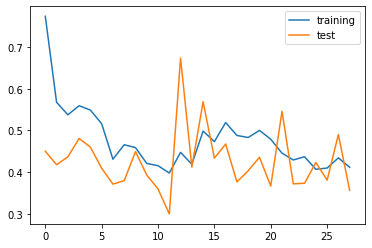

In [22]:
import matplotlib.pyplot as plt

print('1-50')
plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

**2. 두번째 train/valid로 50회 학습**

In [23]:
training_model(50, 50, train[1], valid[1], 14, device, lr=0.001)

epoch 51th training loss: 0.4352185 test loss: 0.3659437, accuracy: 87.8787841796875, precision: 82.17053985595703, recall: 99.06542205810547, f1 score: 89.83050537109375
epoch 55th training loss: 0.3814452 test loss: 0.3018687, accuracy: 89.39393615722656, precision: 86.44068145751953, recall: 95.32710266113281, f1 score: 90.66666412353516
epoch 59th training loss: 0.3791306 test loss: 0.3122919, accuracy: 87.8787841796875, precision: 91.919189453125, recall: 85.0467300415039, f1 score: 88.34951782226562
epoch 63th training loss: 0.4371681 test loss: 0.3143974, accuracy: 83.33333587646484, precision: 85.57691955566406, recall: 83.17756652832031, f1 score: 84.36019134521484
epoch 67th training loss: 0.4539359 test loss: 0.3395183, accuracy: 82.82828521728516, precision: 91.95402526855469, recall: 74.766357421875, f1 score: 82.47422790527344
epoch 71th training loss: 0.375151 test loss: 0.2972795, accuracy: 86.36363983154297, precision: 87.03704071044922, recall: 87.8504638671875, f1 sc

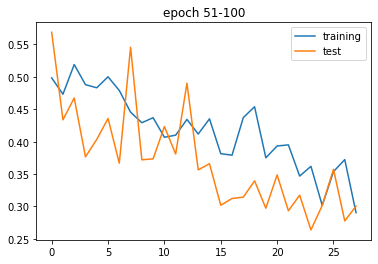

In [24]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[14:], label='training')
plt.plot(list_test_loss[14:], label='test')
plt.title('epoch 51-100')
plt.legend()
plt.show()

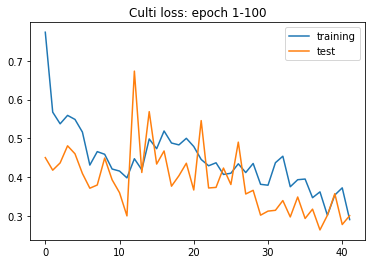

In [25]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-100')
plt.legend()
plt.show()

epoch 100 시점의 test score 계산

In [26]:
# test score:
test_score(model, testloader, device)

accuracy: 88.0, precision: 90.12345886230469, recall: 82.02246856689453, f1 score: 85.8823471069336


**3. 세번째 train/valid로 50회 학습**

In [27]:
training_model(50, 100, train[2], valid[2], 77, device, lr=0.001)

epoch 101th training loss: 0.3321519 test loss: 0.22774, accuracy: 92.42424011230469, precision: 96.90721893310547, recall: 88.67924499511719, f1 score: 92.61084747314453
epoch 105th training loss: 0.436462 test loss: 0.2357984, accuracy: 91.919189453125, precision: 98.91304016113281, recall: 85.84906005859375, f1 score: 91.91919708251953
epoch 109th training loss: 0.3192581 test loss: 0.1824842, accuracy: 93.43434143066406, precision: 94.28571319580078, recall: 93.39622497558594, f1 score: 93.83885955810547
epoch 113th training loss: 0.3033474 test loss: 0.1931948, accuracy: 92.92929077148438, precision: 96.0, recall: 90.5660400390625, f1 score: 93.20388793945312
epoch 117th training loss: 0.3358236 test loss: 0.2017152, accuracy: 92.92929077148438, precision: 96.0, recall: 90.5660400390625, f1 score: 93.20388793945312
epoch 121th training loss: 0.2765565 test loss: 0.1826445, accuracy: 93.43434143066406, precision: 91.89189147949219, recall: 96.2264175415039, f1 score: 94.00921630859

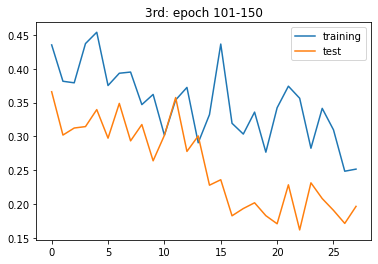

In [28]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[28:], label='training')
plt.plot(list_test_loss[28:], label='test')
plt.title('3rd: epoch 101-150')
plt.legend()
plt.show()

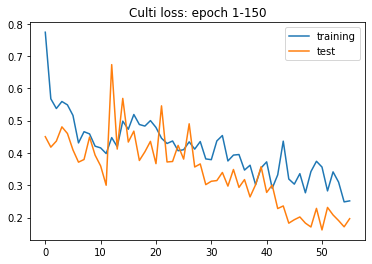

In [29]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-150')
plt.legend()
plt.show()

epoch 150 시점의 test score 계산

In [30]:
# test score:
test_score(model, testloader, device)

accuracy: 86.5, precision: 86.9047622680664, recall: 82.02246856689453, f1 score: 84.39305877685547


**4. 네번째 train/valid로 50회 학습**

In [31]:
training_model(50, 150, train[3], valid[3], 256, device, lr=0.001)

epoch 151th training loss: 0.3161141 test loss: 0.0868199, accuracy: 96.46464538574219, precision: 98.95833587646484, recall: 94.05940246582031, f1 score: 96.44670104980469
epoch 155th training loss: 0.3220226 test loss: 0.1201107, accuracy: 97.47474670410156, precision: 98.0, recall: 97.02970123291016, f1 score: 97.51244354248047
epoch 159th training loss: 0.307017 test loss: 0.1284041, accuracy: 96.46464538574219, precision: 97.95918273925781, recall: 95.04950714111328, f1 score: 96.48240661621094
epoch 163th training loss: 0.3399633 test loss: 0.1282817, accuracy: 96.46464538574219, precision: 96.07843017578125, recall: 97.02970123291016, f1 score: 96.55171966552734
epoch 167th training loss: 0.2685978 test loss: 0.1327172, accuracy: 97.47474670410156, precision: 98.9795913696289, recall: 96.03960418701172, f1 score: 97.48744201660156
epoch 171th training loss: 0.3263631 test loss: 0.1387244, accuracy: 95.9595947265625, precision: 96.96969604492188, recall: 95.04950714111328, f1 sco

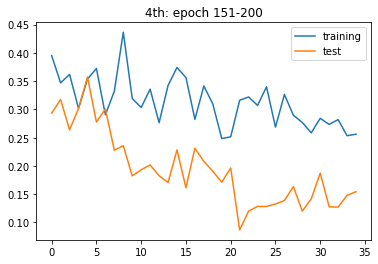

In [32]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[35:], label='training')
plt.plot(list_test_loss[35:], label='test')
plt.title('4th: epoch 151-200')
plt.legend()
plt.show()

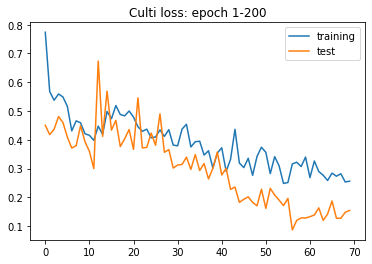

In [33]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-200')
plt.legend()
plt.show()

epoch 200 시점의 test score 계산

In [34]:
#test score:
test_score(model, testloader, device)

accuracy: 86.0, precision: 79.04762268066406, recall: 93.25843048095703, f1 score: 85.56700897216797


In [ ]:
torch.save(model, 'model_cough200.pt') 

**5. 다섯번째 train/valid로 50회 학습**

In [35]:
training_model(50, 200, train[4], valid[4], 122, device, lr=0.001)

epoch 201th training loss: 0.280643 test loss: 0.0630682, accuracy: 97.47474670410156, precision: 95.78947448730469, recall: 98.91304016113281, f1 score: 97.32620239257812
epoch 205th training loss: 0.2663051 test loss: 0.0711194, accuracy: 97.47474670410156, precision: 96.7741928100586, recall: 97.82608795166016, f1 score: 97.29730224609375
epoch 209th training loss: 0.2848383 test loss: 0.0990319, accuracy: 96.96969604492188, precision: 95.74468231201172, recall: 97.82608795166016, f1 score: 96.77420043945312
epoch 213th training loss: 0.2325668 test loss: 0.1258513, accuracy: 97.97979736328125, precision: 97.82608795166016, recall: 97.82608795166016, f1 score: 97.82608795166016
epoch 217th training loss: 0.253726 test loss: 0.1388755, accuracy: 96.96969604492188, precision: 95.74468231201172, recall: 97.82608795166016, f1 score: 96.77420043945312
epoch 221th training loss: 0.2929714 test loss: 0.1122247, accuracy: 96.96969604492188, precision: 95.74468231201172, recall: 97.826087951

In [36]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[42:], label='training')
plt.plot(list_test_loss[42:], label='test')
plt.title('5th: epoch 201-250')
plt.legend()
plt.show()

In [37]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-250')
plt.legend()
plt.show()

In [38]:
# 최종 test score
test_score(model, testloader, device)

accuracy: 84.0, precision: 80.6451644897461, recall: 84.26966094970703, f1 score: 82.4175796508789


In [39]:
torch.save(model, 'model_cough250.pt') 

In [40]:
model.eval()
y_test = None
y_pred = None
for test_data, test_target in testloader:
    test_data = test_data.to(device)
    y = model(test_data)
    idx_pred = torch.max(y, 1)[1]
    if y_test == None:
        y_test = test_target
    else:
        y_test = torch.cat([y_test, test_target], dim=0)
    if y_pred == None:
        y_pred = idx_pred
    else:
        y_pred = torch.cat([y_pred, idx_pred], dim=0)

In [41]:
y_pred

tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')

In [42]:
y_test

tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 0])

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test.detach().cpu(), y_pred.detach().cpu())

In [44]:
print(confusion_matrix)

[[75 14]
 [18 93]]


In [46]:
import itertools

In [47]:
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
plt.title('Confusion Martix')
plt.colorbar()
plt.xticks([0,1],labels=['cough','non-cough'])
plt.yticks([0,1],labels=['cough','non-cough'])
plt.xlabel('True label')
plt.ylabel('Predicted label')

for i, j in itertools.product(range(2), range(2)):
  if confusion_matrix[i, j] < 50:
    plt.text(j, i, confusion_matrix[i, j], horizontalalignment="center", color="black")
  else:
    plt.text(j, i, confusion_matrix[i, j], horizontalalignment="center", color="white")
plt.show()